# League of Legends prediction

### The Data

The data used in this notebook was scraped from the web by none other than myself. [the repo can be found here.](https://github.com/5ause/league-scrapev2)

The data measures over 200 variables for over 1000 games of the popular game, League of Legends. In this notebook, I will attempt to create a model that predicts the outcome of a League game, given the stats.

Some things to note:
 - The games that I scraped are challenger elo games, meaning they are played by good players. This means that their gameplay is more consistent, implying that, when you match the same players against each other over and over, the outcome will be relatively consistent. I do not know if the same can be said for lower elo(worse) players

## Uploading the data and importing libraries

In [2]:
from google.colab import files

In [3]:
# upload data.csv
uploaded = files.upload()

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import csv

## First look at the data

There are 232 variables being measured. Most of these variables are numeric, and some are not.

Some of these columns must be converted to a numeric representation, or otherwise mutated, in order to produce insightful variables.

For my first model, I will only select the numeric variables.

In [6]:
df = pd.read_csv('data.csv')

In [7]:
df.head()

,gameid,winning_team,100_TOP_avg_game_time,100_TOP_positions_played,100_TOP_avg_kda,100_TOP_avg_kp,100_TOP_avg_vision,100_TOP_avg_cs,100_TOP_goldpm,100_TOP_dmgpm,100_TOP_dmg_to_obj_pm,100_TOP_wr,100_TOP_tier,100_TOP_rank,100_TOP_lp,100_TOP_wins,100_TOP_losses,100_TOP_veteran,100_TOP_inactive,100_TOP_freshblood,100_TOP_hotstreak,100_TOP_role_total_played,100_TOP_role_wr,100_TOP_champ_games_played,100_TOP_champ_winrate,100_JUNGLE_avg_game_time,100_JUNGLE_positions_played,100_JUNGLE_avg_kda,100_JUNGLE_avg_kp,100_JUNGLE_avg_vision,100_JUNGLE_avg_cs,100_JUNGLE_goldpm,100_JUNGLE_dmgpm,100_JUNGLE_dmg_to_obj_pm,100_JUNGLE_wr,100_JUNGLE_tier,100_JUNGLE_rank,100_JUNGLE_lp,100_JUNGLE_wins,100_JUNGLE_losses,...,200_BOTTOM_goldpm,200_BOTTOM_dmgpm,200_BOTTOM_dmg_to_obj_pm,200_BOTTOM_wr,200_BOTTOM_tier,200_BOTTOM_rank,200_BOTTOM_lp,200_BOTTOM_wins,200_BOTTOM_losses,200_BOTTOM_veteran,200_BOTTOM_inactive,200_BOTTOM_freshblood,200_BOTTOM_hotstreak,200_BOTTOM_role_total_played,200_BOTTOM_role_wr,200_BOTTOM_champ_games_played,200_BOTTOM_champ_winrate,200_UTILITY_avg_game_time,200_UTILITY_positions_played,200_UTILITY_avg_kda,200_UTILITY_avg_kp,200_UTILITY_avg_vision,200_UTILITY_avg_cs,200_UTILITY_goldpm,200_UTILITY_dmgpm,200_UTILITY_dmg_to_obj_pm,200_UTILITY_wr,200_UTILITY_tier,200_UTILITY_rank,200_UTILITY_lp,200_UTILITY_wins,200_UTILITY_losses,200_UTILITY_veteran,200_UTILITY_inactive,200_UTILITY_freshblood,200_UTILITY_hotstreak,200_UTILITY_role_total_played,200_UTILITY_role_wr,200_UTILITY_champ_games_played,200_UTILITY_champ_winrate
0,NA1_4144890019,200,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,4,0.250000,23.598333,JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNG...,6.859524,0.531200,19.2,5.322410,434.695953,580.689314,773.656332,0.5,CHALLENGER,I,1223,151,91,...,444.018576,727.816718,317.008050,0.8,GRANDMASTER,I,852,397,356,True,False,False,False,202,0.539604,36,0.555556,25.183333,BOTTOM BOTTOM BOTTOM BOTTOM UTILITY JUNGLE JUN...,3.513095,0.414308,37.1,5.102581,374.791529,439.441429,364.530774,0.4,GRANDMASTER,I,825,419,389,False,False,False,False,616,0.524351,25,0.360000
1,NA1_4142559007,200,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,22,0.500000,24.556667,JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNG...,5.588333,0.545225,20.6,7.452151,471.745622,768.023619,1009.444822,0.5,GRANDMASTER,I,493,148,112,...,482.375967,615.133624,140.509786,0.5,GRANDMASTER,I,495,424,380,True,False,False,False,35,0.714286,212,0.570755,28.300000,UTILITY UTILITY UTILITY UTILITY TOP JUNGLE UTI...,1.660960,0.506136,49.5,2.770318,326.858657,471.254417,135.872792,0.1,GRANDMASTER,I,651,592,507,False,False,False,False,941,0.547290,25,0.520000
2,NA1_4141413442,200,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,4,0.250000,23.765000,JUNGLE JUNGLE JUNGLE TOP JUNGLE JUNGLE JUNGLE ...,3.637258,0.420519,20.1,7.317484,450.031559,643.980644,892.699348,0.4,GRANDMASTER,I,502,156,112,...,446.584003,666.117488,441.217850,0.4,GRANDMASTER,I,650,613,584,True,False,False,False,1024,0.515625,159,0.515723,27.480000,BOTTOM BOTTOM TOP BOTTOM BOTTOM BOTTOM BOTTOM ...,2.441634,0.507755,28.5,8.155022,502.503639,979.497817,501.419214,0.6,CHALLENGER,I,1387,417,349,True,False,False,False,28,0.500000,6,0.833333
3,NA1_4111370048,200,24.110000,MIDDLE TOP TOP TOP TOP TOP TOP TOP TOP TOP,1.912560,0.368992,16.5,6.744090,424.682704,688.888428,230.514309,0.4,CHALLENGER,I,1032,719,666,True,False,False,False,1130,0.535398,33,0.575758,26.801667,MIDDLE MIDDLE TOP MIDDLE JUNGLE MIDDLE MIDDLE ...,3.301111,0.386141,19.0,6.395125,418.854549,655.959207,285.068093,0.6,CHALLENGER,I,897,201,150,...,404.009017,649.48

In [8]:
df.columns

Index(['gameid', 'winning_team', '100_TOP_avg_game_time',
       '100_TOP_positions_played', '100_TOP_avg_kda', '100_TOP_avg_kp',
       '100_TOP_avg_vision', '100_TOP_avg_cs', '100_TOP_goldpm',
       '100_TOP_dmgpm',
       ...
       '200_UTILITY_wins', '200_UTILITY_losses', '200_UTILITY_veteran',
       '200_UTILITY_inactive', '200_UTILITY_freshblood',
       '200_UTILITY_hotstreak', '200_UTILITY_role_total_played',
       '200_UTILITY_role_wr', '200_UTILITY_champ_games_played',
       '200_UTILITY_champ_winrate'],
      dtype='object', length=232)

## NA Values

Lots of champ winrates are missing from the table. This likely occurs when a player hasn't played their current character at all before(meaning they were likely filled into their role).

I think it's reasonable to fill the NA values with either the mean of all the winrate values, or simply 0.5(because that's the theoretical probability of winning any game of League of Legends).

I opted to fill the NA values with the mean.

In [9]:
a = df.isnull().sum(axis=0)

na_count = total = a.sort_values(ascending=False)

na_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([na_count, na_percent], axis=1, keys=["Total", "Percent"])

missing_data.head(20)

,Total,Percent
200_BOTTOM_champ_winrate,154,0.1232
100_BOTTOM_champ_winrate,149,0.1192
200_JUNGLE_champ_winrate,86,0.0688
100_JUNGLE_champ_winrate,80,0.0640
100_TOP_champ_winrate,47,0.0376
200_TOP_champ_winrate,39,0.0312
200_MIDDLE_champ_winrate,18,0.0144
100_MIDDLE_champ_winrate,11,0.0088
200_UTILITY_champ_winrate,7,0.0056
100_UTILITY_champ_winrate,4,0.0032


In [10]:
df[missing_data.index].mean().head(20)

200_BOTTOM_champ_winrate           0.535309
100_BOTTOM_champ_winrate           0.543992
200_JUNGLE_champ_winrate           0.539161
100_JUNGLE_champ_winrate           0.546143
100_TOP_champ_winrate              0.550151
200_TOP_champ_winrate              0.537295
200_MIDDLE_champ_winrate           0.538542
100_MIDDLE_champ_winrate           0.540741
200_UTILITY_champ_winrate          0.529577
100_UTILITY_champ_winrate          0.546381
200_MIDDLE_role_total_played     411.044836
200_MIDDLE_role_wr                 0.531473
100_BOTTOM_avg_cs                  6.424231
100_BOTTOM_goldpm                426.277087
100_BOTTOM_avg_kp                  0.464632
100_BOTTOM_avg_kda                 3.405743
100_BOTTOM_dmgpm                 674.561730
100_BOTTOM_dmg_to_obj_pm         367.243819
100_BOTTOM_avg_vision             21.887356
100_MIDDLE_champ_games_played    186.977600
dtype: float64

In [11]:
df["winning_team"] = df["winning_team"].apply(lambda x : int(str(x) == "100"))

In [12]:
df.rename(columns={"winning_team": "100_win"}, inplace=True)

I kind of want to just fill na with average values and see what happens, because in other papers, champ winrates were shown to be really important.

In [13]:
df.fillna(df.mean(), inplace=True)

df.isnull().sum(axis=0).sort_values(ascending=False)
# ok good

200_UTILITY_champ_winrate      0
100_BOTTOM_positions_played    0
100_BOTTOM_wins                0
100_BOTTOM_lp                  0
100_BOTTOM_rank                0
                              ..
200_JUNGLE_tier                0
200_JUNGLE_wr                  0
200_JUNGLE_dmg_to_obj_pm       0
200_JUNGLE_dmgpm               0
gameid                         0
Length: 232, dtype: int64

##Let's create training and testing datasets

(this is gonna vary every time because it randomly assigns training and testing)

In [14]:
msk = np.random.rand(len(df)) < 0.8

In [15]:
# StackOverflow informed me that this would work...
train = df[msk]
test = df[~msk]

In [16]:
print(len(test), len(train))

257 993


## Now let's do some basic exploration of the data

Here, I started looking at variables and quickly realized that I don't actually have much training in this area, and all I can do is say "oh this graph looks like a normal distribution" and do absolutely nothing about it.

I just looked at a few graphs, made sure that I had a similar number of wins from each team(because I don't want the game results to be skewed) and called it a day.

In [17]:
print(train["100_BOTTOM_goldpm"].describe(), "\n")
print(train["200_BOTTOM_goldpm"].describe())

count    993.000000
mean     426.678019
std       59.647935
min        0.497829
25%      405.051453
50%      430.943254
75%      458.680776
max      603.741722
Name: 100_BOTTOM_goldpm, dtype: float64 

count    993.000000
mean     424.045047
std       64.240946
min        0.505774
25%      399.427810
50%      428.611144
75%      458.941696
max      612.021226
Name: 200_BOTTOM_goldpm, dtype: float64


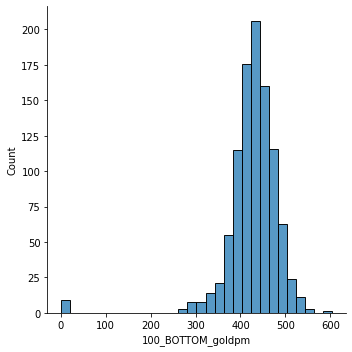

In [18]:
sns.displot(train["100_BOTTOM_goldpm"], bins=30)
# negatively(left) skewed a bit, unimodal, deviates from the normal distribution

In [19]:
print("Skewness: %f" % train['100_BOTTOM_goldpm'].skew())
print("Kurtosis: %f" % train['100_BOTTOM_goldpm'].kurt())
# kurtosis is basically a measure of whether the data follows a normal distribution
# especially with respect to tails
# high kurtosis --> heavy tails, more outliers

Skewness: -3.310795
Kurtosis: 21.650972


In [20]:
train["100_win"].value_counts()

1    537
0    456
Name: 100_win, dtype: int64

## Some more(useless) data analysis

Did not result in any findings. Skip if you desire.

I got a tip from Twitter that personal champ winrates(the player's winrate on the character they are currently playing in the match) was important to look at.

Here, basically I realized that looking at graphs wouldn't do me any good, so I should look at metrics instead.

In [21]:
win_100 = train[train["100_win"] == 1]
win_200 = train[train["100_win"] == 0]

(0.0, 1.0)

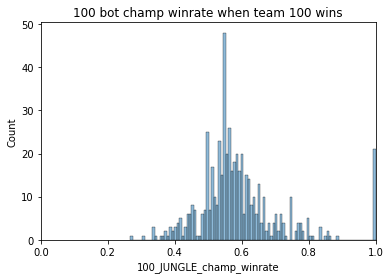

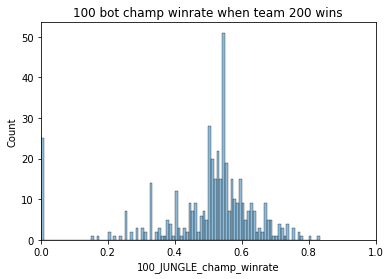

In [22]:
ax1 = sns.histplot(win_100['100_JUNGLE_champ_winrate'], bins=100, alpha=0.5, label="100_win")
ax1.title.set_text("100 bot champ winrate when team 100 wins")
ax1.set_xlim([0, 1])
plt.figure()
ax2 = sns.histplot(win_200['100_JUNGLE_champ_winrate'], bins=100, alpha=0.5, label="200_win")
ax2.title.set_text("100 bot champ winrate when team 200 wins")
ax2.set_xlim([0, 1])

## Further investigation of champ, role winrates

So here, we took the ____ winrate of each player on team 100, and measured the average champ winrate when team 100 wins, and when team 200 wins.

Turns out that on average, the players on the winning team average 60% winrate on their individual champion, versus 50% winrate on their individual champion when they lose.

The role winrate for players are slightly higher on the winning team, compared to the losing team.

In [23]:
for role in ["JUNGLE", "BOTTOM", "MIDDLE", "TOP", "UTILITY"]:
  print(role)
  print("100:", win_100[f'100_{role}_champ_winrate'].mean(), "\n200:", win_200[f'100_{role}_champ_winrate'].mean())

JUNGLE
100: 0.5903502184650365 
200: 0.4951663212496821
BOTTOM
100: 0.5776973841604597 
200: 0.509525380934063
MIDDLE
100: 0.5831963601899003 
200: 0.4852682007588659
TOP
100: 0.586416185287136 
200: 0.5002091248560573
UTILITY
100: 0.5799268976315208 
200: 0.4873704174568836


In [24]:
# let's check out role winrates too
for role in ["JUNGLE", "BOTTOM", "MIDDLE", "TOP", "UTILITY"]:
  print(role)
  print("100:", win_100[f'100_{role}_role_wr'].mean(), "\n200:", win_200[f'100_{role}_role_wr'].mean())

JUNGLE
100: 0.5477766066309729 
200: 0.5343857924887455
BOTTOM
100: 0.5440854549733636 
200: 0.5280786204289885
MIDDLE
100: 0.5360746891791545 
200: 0.5164823538175565
TOP
100: 0.5485555440094464 
200: 0.5286221204824453
UTILITY
100: 0.5360872787835478 
200: 0.5186064597387401


# Let's look at the variables that are most different when the winning team changes value...

I got this idea from the last part of the investigation. What if I just look at the variables that are the most different depending on which team wins?

Read below for conclusions

In [25]:
mean_100 = win_100.mean()
mean_200 = win_200.mean()

In [26]:
# just checking that I did things right D:
mean_100["100_UTILITY_champ_winrate"]

0.5799268976315208

In [27]:
# difference in means when team 100 wins vs when team 200 wins
mean_diff = mean_100 - mean_200

In [28]:
highest_diffs = mean_diff.drop("100_win").sort_values()

In [29]:
# some variables are just kinda weird and NEED PROCESSING
# for example, some avg_game_times are super high because the league client returned
# milliseconds for the old versions of the thing, vs seconds for the new version...
# OOPS well I guess I didn't know that...
# but I think we'll not use these variables anyways...
train["100_TOP_avg_game_time"].sort_values()

152        18.286667
279        19.113333
233        20.025000
206        20.025000
236        20.025000
            ...     
355     14038.386667
430     15019.476667
374     18477.796667
1143    21196.701667
835     25053.441667
Name: 100_TOP_avg_game_time, Length: 993, dtype: float64

In [30]:
train_sd = train.std()

In [31]:
mean_diff_adjusted = mean_diff / train_sd

In [32]:
mean_diff_adjusted.sort_values().head(20)

200_MIDDLE_champ_winrate    -0.625354
200_JUNGLE_champ_winrate    -0.573938
200_UTILITY_champ_winrate   -0.564484
200_TOP_champ_winrate       -0.539281
200_MIDDLE_wr               -0.486551
200_TOP_wr                  -0.470021
200_JUNGLE_wr               -0.453089
200_UTILITY_wr              -0.444558
200_BOTTOM_champ_winrate    -0.404120
200_BOTTOM_wr               -0.395544
200_JUNGLE_avg_kda          -0.318000
200_TOP_hotstreak           -0.297123
200_JUNGLE_dmg_to_obj_pm    -0.283777
200_TOP_role_wr             -0.278821
200_UTILITY_role_wr         -0.268240
200_UTILITY_avg_kda         -0.266666
200_MIDDLE_role_wr          -0.264097
200_BOTTOM_hotstreak        -0.262720
200_JUNGLE_goldpm           -0.244886
200_JUNGLE_role_wr          -0.231876
dtype: float64

In [33]:
mean_diff_adjusted.sort_values(ascending=False).head(20)
# ok maybe I should've really cleaned the data and dealt with NA values and stuff huh...

100_win                      2.005677
100_JUNGLE_champ_winrate     0.633574
100_MIDDLE_champ_winrate     0.620157
100_UTILITY_champ_winrate    0.604361
100_TOP_champ_winrate        0.581240
100_BOTTOM_champ_winrate     0.538068
100_TOP_wr                   0.439553
100_MIDDLE_wr                0.408207
100_UTILITY_wr               0.406847
100_JUNGLE_wr                0.392244
100_UTILITY_hotstreak        0.373171
100_BOTTOM_wr                0.330942
100_TOP_role_wr              0.305952
100_BOTTOM_hotstreak         0.273721
100_JUNGLE_avg_kda           0.266237
100_MIDDLE_role_wr           0.254283
100_BOTTOM_role_wr           0.251981
100_MIDDLE_avg_kda           0.249006
100_JUNGLE_lp                0.228188
100_TOP_lp                   0.223799
dtype: float64

Ok so this is some scuffed z-score thing...

I took the means of each variable when team 100 wins, compared to when team 200 wins. I then took the standard deviation of each variable. Finally, I did a z-score kind of thing and checked which variables deviated the most, depending on which team wins.

for example, the allied team adc(a role in LoL)'s winrate is, on average, around .5(value changes when I reload the notebook) standard deviations higher when the allied team wins, compared to when the enemy team(200) wins.

It seems like my suspicions were true. As the guy on twitter said, individual champ winrates seem to have the most "impact"(I feel like I need to plot some stuff or whatever to check, but there's the most average difference depending on the match outcome), and that is followed by ranked winrates.

There's some hotstreak, role_wr, avg_kda mixed in there...I'm just kind of scared because that was like the average kda across the last 10 games, and idk... the data's telling me there's a correlation, but I guess I have a lot more exploring to do.

On the other side of things, champ winrates for players on the enemy team, and overall ranked winrates for enemy players, are higher when the enemy team wins. We see the same variables there, which is consistent with our other findings.

# Correlation matrix

I learned this from a guy on Kaggle.com, apparently it's a good method to see if predictor variables are correlated with each other(as you can remove one if they are)

By intuition, since players are matched at random, their winrate, champ winrate etc. shouldn't be correlated with the other player's stats.

Open this section for conclusions, basically there wasn't much correlation.

In [34]:
train.head()

,gameid,100_win,100_TOP_avg_game_time,100_TOP_positions_played,100_TOP_avg_kda,100_TOP_avg_kp,100_TOP_avg_vision,100_TOP_avg_cs,100_TOP_goldpm,100_TOP_dmgpm,100_TOP_dmg_to_obj_pm,100_TOP_wr,100_TOP_tier,100_TOP_rank,100_TOP_lp,100_TOP_wins,100_TOP_losses,100_TOP_veteran,100_TOP_inactive,100_TOP_freshblood,100_TOP_hotstreak,100_TOP_role_total_played,100_TOP_role_wr,100_TOP_champ_games_played,100_TOP_champ_winrate,100_JUNGLE_avg_game_time,100_JUNGLE_positions_played,100_JUNGLE_avg_kda,100_JUNGLE_avg_kp,100_JUNGLE_avg_vision,100_JUNGLE_avg_cs,100_JUNGLE_goldpm,100_JUNGLE_dmgpm,100_JUNGLE_dmg_to_obj_pm,100_JUNGLE_wr,100_JUNGLE_tier,100_JUNGLE_rank,100_JUNGLE_lp,100_JUNGLE_wins,100_JUNGLE_losses,...,200_BOTTOM_goldpm,200_BOTTOM_dmgpm,200_BOTTOM_dmg_to_obj_pm,200_BOTTOM_wr,200_BOTTOM_tier,200_BOTTOM_rank,200_BOTTOM_lp,200_BOTTOM_wins,200_BOTTOM_losses,200_BOTTOM_veteran,200_BOTTOM_inactive,200_BOTTOM_freshblood,200_BOTTOM_hotstreak,200_BOTTOM_role_total_played,200_BOTTOM_role_wr,200_BOTTOM_champ_games_played,200_BOTTOM_champ_winrate,200_UTILITY_avg_game_time,200_UTILITY_positions_played,200_UTILITY_avg_kda,200_UTILITY_avg_kp,200_UTILITY_avg_vision,200_UTILITY_avg_cs,200_UTILITY_goldpm,200_UTILITY_dmgpm,200_UTILITY_dmg_to_obj_pm,200_UTILITY_wr,200_UTILITY_tier,200_UTILITY_rank,200_UTILITY_lp,200_UTILITY_wins,200_UTILITY_losses,200_UTILITY_veteran,200_UTILITY_inactive,200_UTILITY_freshblood,200_UTILITY_hotstreak,200_UTILITY_role_total_played,200_UTILITY_role_wr,200_UTILITY_champ_games_played,200_UTILITY_champ_winrate
0,NA1_4144890019,0,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,4,0.250000,23.598333,JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNG...,6.859524,0.531200,19.2,5.322410,434.695953,580.689314,773.656332,0.5,CHALLENGER,I,1223,151,91,...,444.018576,727.816718,317.008050,0.8,GRANDMASTER,I,852,397,356,True,False,False,False,202,0.539604,36,0.555556,25.183333,BOTTOM BOTTOM BOTTOM BOTTOM UTILITY JUNGLE JUN...,3.513095,0.414308,37.1,5.102581,374.791529,439.441429,364.530774,0.4,GRANDMASTER,I,825,419,389,False,False,False,False,616,0.524351,25,0.360000
1,NA1_4142559007,0,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,22,0.500000,24.556667,JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUNG...,5.588333,0.545225,20.6,7.452151,471.745622,768.023619,1009.444822,0.5,GRANDMASTER,I,493,148,112,...,482.375967,615.133624,140.509786,0.5,GRANDMASTER,I,495,424,380,True,False,False,False,35,0.714286,212,0.570755,28.300000,UTILITY UTILITY UTILITY UTILITY TOP JUNGLE UTI...,1.660960,0.506136,49.5,2.770318,326.858657,471.254417,135.872792,0.1,GRANDMASTER,I,651,592,507,False,False,False,False,941,0.547290,25,0.520000
2,NA1_4141413442,0,23.271667,TOP TOP TOP TOP TOP TOP TOP BOTTOM TOP TOP,2.344102,0.421483,19.9,7.399556,450.255676,660.584402,430.506338,0.5,GRANDMASTER,I,765,98,82,False,False,False,False,168,0.553571,4,0.250000,23.765000,JUNGLE JUNGLE JUNGLE TOP JUNGLE JUNGLE JUNGLE ...,3.637258,0.420519,20.1,7.317484,450.031559,643.980644,892.699348,0.4,GRANDMASTER,I,502,156,112,...,446.584003,666.117488,441.217850,0.4,GRANDMASTER,I,650,613,584,True,False,False,False,1024,0.515625,159,0.515723,27.480000,BOTTOM BOTTOM TOP BOTTOM BOTTOM BOTTOM BOTTOM ...,2.441634,0.507755,28.5,8.155022,502.503639,979.497817,501.419214,0.6,CHALLENGER,I,1387,417,349,True,False,False,False,28,0.500000,6,0.833333
5,NA1_4144616999,1,22.896667,TOP JUNGLE TOP TOP TOP TOP TOP JUNGLE TOP TOP,2.857677,0.424002,18.4,6.066385,390.126656,599.157083,274.245159,0.3,GRANDMASTER,I,632,235,214,False,False,False,False,370,0.540541,6,0.833333,24.456667,UTILITY JUNGLE JUNGLE JUNGLE JUNGLE JUNGLE JUN...,4.596825,0.512282,34.0,4.747172,345.721685,274.379174,303.156604,0.4,CHALLENGER,I,987,352,309,...,373.445221,387.002331,159.65

In [35]:
k = 20
corrmat = train.corr()

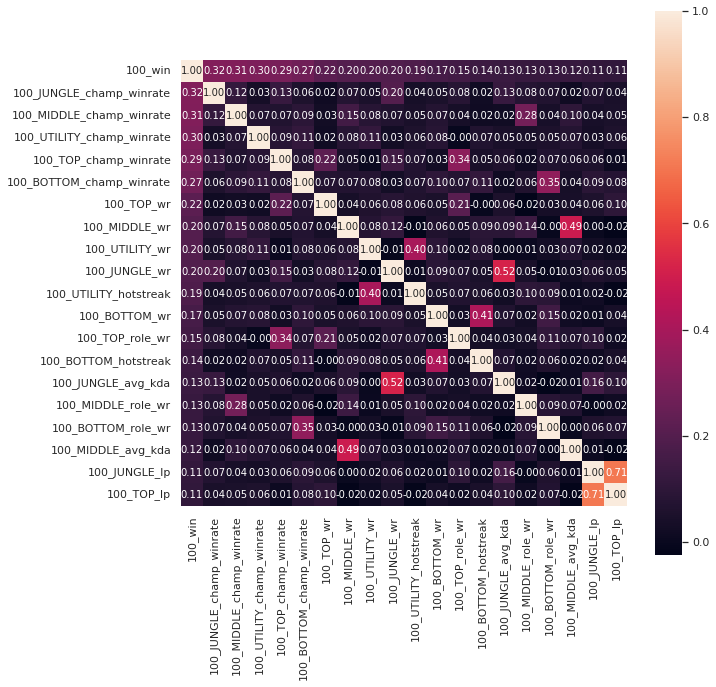

In [36]:
k = 20
cols = corrmat.nlargest(k, "100_win")["100_win"].index
df_conv = train[cols].astype(float)

cm = np.corrcoef(df_conv[cols].values.T)

sns.set(font_scale=1)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Correlation conclusions:

Ok so, as expected, most variables aren't highly correlated with each other, because logically, the players are randomly queued so of course their winrates wouldn't be similar.

We do see that variables related to one individual are somewhat correlated(eg. team 100 jungler's average kda has a correlation of 0.5 with team 100 jungler's winrate)

I think this isn't too big of a problem, as nothing is super highly correlated...?

In other projects, typically a high correlation is like >0.7, I don't know if a correlation of 0.5 even matters(cuz I haven't even taken my data science course yet)

# Model time?

Alright, I've learned a few things, I guess?

I haven't learned about proper data cleaning or anything at the moment, so I think I'll just fit my first model...

In [37]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

In [38]:
train_y = train["100_win"]
train_x = train.drop(["100_win"], axis=1)

In [39]:
# I forgot to look at dtypes D:
object_type = train_x.dtypes == object
object_type.sort_values(ascending=False).head(40)
# ok all the object dtypes come from non-numeric/boolean columns. I guess for the first model I'll just drop them all
# as none of them are that important(unless if we use them to create new variables...)

gameid                           True
200_JUNGLE_positions_played      True
200_TOP_rank                     True
100_JUNGLE_positions_played      True
200_BOTTOM_rank                  True
100_BOTTOM_rank                  True
100_BOTTOM_tier                  True
100_JUNGLE_tier                  True
100_JUNGLE_rank                  True
200_BOTTOM_positions_played      True
100_BOTTOM_positions_played      True
200_UTILITY_positions_played     True
200_JUNGLE_tier                  True
100_MIDDLE_positions_played      True
200_JUNGLE_rank                  True
200_MIDDLE_rank                  True
200_MIDDLE_tier                  True
100_MIDDLE_tier                  True
200_MIDDLE_positions_played      True
100_MIDDLE_rank                  True
200_TOP_tier                     True
200_BOTTOM_tier                  True
100_UTILITY_tier                 True
100_TOP_positions_played         True
100_UTILITY_positions_played     True
100_UTILITY_rank                 True
200_UTILITY_

In [40]:
indexes_to_drop = object_type[object_type == True].index

In [41]:
train_x.drop(indexes_to_drop, axis=1, inplace=True)

In [65]:
random_state = 7
n_estimators = 100

model1 = RandomForestClassifier(random_state=random_state, n_estimators = n_estimators)
model1.fit(train_x, train_y)

RandomForestClassifier(random_state=7)

In [66]:
print(model1.n_features_in_)
print(len(train_x.columns))

200
200


In [67]:
feature_importances = pd.concat([pd.DataFrame(model1.feature_names_in_), pd.DataFrame(model1.feature_importances_)], axis=1)
feature_importances.columns = ["feature", "importance"]
feature_importances.head()

,feature,importance
0,100_TOP_avg_game_time,0.004543
1,100_TOP_avg_kda,0.006931
2,100_TOP_avg_kp,0.003454
3,100_TOP_avg_vision,0.004765
4,100_TOP_avg_cs,0.005381


In [68]:
feature_importances.sort_values(by="importance", ascending=False).head(20)

,feature,importance
99,100_UTILITY_champ_winrate,0.031197
39,100_JUNGLE_champ_winrate,0.027271
159,200_MIDDLE_champ_winrate,0.025112
59,100_MIDDLE_champ_winrate,0.024655
19,100_TOP_champ_winrate,0.023988
139,200_JUNGLE_champ_winrate,0.021291
199,200_UTILITY_champ_winrate,0.018967
119,200_TOP_champ_winrate,0.018292
79,100_BOTTOM_champ_winrate,0.017933
148,200_MIDDLE_wr,0.013612


## Creating the model part 2

Ok so basically I did a bunch of exploration, did minimal cleaning and now I've fitted a random forest classifier. No idea how accurate it is(even on the training data), but it's good to see that it placed importance on the things I thought it would.

It's time to look at the model accuracy on the training data and stuff.

In [69]:
pred_y = model1.predict(train_x)
accuracy_train = metrics.accuracy_score(train_y, pred_y)
print("training accuracy:", accuracy_train)

training accuracy: 1.0


This is not good. Possible reasons to explore:
 - did my training data include duplicates...like a lot of duplicates? I don't think so, because I coded it to not gather data for the same gameid twice, but I guess I should check...
 - is my model overfitting(probably) --> I don't even know what to say here...like a training accuracy of 100% means the model is probably overfitted, right?
 - is my DATA just collected badly? (more on that later)

 I was so shocked that I had to verify myself. I did not trust the accuracy_score.

In [70]:
pd.concat([pd.DataFrame(train_y), pd.DataFrame(pred_y)], axis=1, ignore_index=True)

,0,1
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,NaN,1.0
4,NaN,1.0
...,...,...
1244,1.0,NaN
1245,1.0,NaN
1246,0.0,NaN
1248,0.0,NaN


In [71]:
print(train_y.isnull().sum())
print(pd.DataFrame(pred_y).isnull().sum())
print(len(train_y), len(pd.DataFrame(pred_y)))

0
0    0
dtype: int64
993 993


In [72]:
predicted_scores = pd.DataFrame(pred_y)[0]

In [73]:
predicted_scores.reset_index(drop=True, inplace=True)
y_train_index_dropped = train_y.reset_index(drop=True)

In [74]:
pred_train_tbl = pd.concat([predicted_scores, y_train_index_dropped], axis=1)
pred_train_tbl.head()

,0,100_win
0,0,0
1,0,0
2,0,0
3,1,1
4,1,1


In [75]:
(pred_train_tbl[0] == pred_train_tbl["100_win"]).sum()

993

## Moving on...

Ok so either the model is really overfit(it 100% is)

or something went wrong(probably this one)

let's try predicting on the test data and see what happens...

In [76]:
train_x.columns

Index(['100_TOP_avg_game_time', '100_TOP_avg_kda', '100_TOP_avg_kp',
       '100_TOP_avg_vision', '100_TOP_avg_cs', '100_TOP_goldpm',
       '100_TOP_dmgpm', '100_TOP_dmg_to_obj_pm', '100_TOP_wr', '100_TOP_lp',
       ...
       '200_UTILITY_wins', '200_UTILITY_losses', '200_UTILITY_veteran',
       '200_UTILITY_inactive', '200_UTILITY_freshblood',
       '200_UTILITY_hotstreak', '200_UTILITY_role_total_played',
       '200_UTILITY_role_wr', '200_UTILITY_champ_games_played',
       '200_UTILITY_champ_winrate'],
      dtype='object', length=200)

In [77]:
test_y = test["100_win"]
test_x = test[train_x.columns]

In [78]:
pred_test = model1.predict(test_x)

In [79]:
accuracy_test = metrics.accuracy_score(test_y, pred_test)
print("accuracy:", accuracy_test)

accuracy: 0.77431906614786


85% accuracy? that's good I guess...unless if my DATA is bad!!

I have no idea what happened but I'LL TAKE IT!!

Note: I reloaded the notebook and got 77% accuracy...

How did I get 100% training accuracy tho...I think I'll mess around with the random forest parameters and see if anything happens...

I'll just serialize the model for now

## Model metrics

eg. Confusion Matrix

In [57]:
confusion = metrics.confusion_matrix(test_y, pred_test)
print(f"Confusion matrix:\n{confusion}")

# TP FP
# FN TN

Confusion matrix:
[[ 84  44]
 [ 14 115]]


ok but see I reloaded the notebook and now I have a 77% accuracy...

85% True Positive rate, 72% True Negative rate

In [58]:
import pickle

In [59]:
file = open("model1.bin", "wb")
pickle.dump(model1, file)
file.close()

In [60]:
import json

In [61]:
with open("req_columns.json", "w") as file:
  json.dump(list(train_x.columns), file)

In [62]:
mean_dict = df.mean().to_dict()

In [63]:
with open("avgvalues.json", "w") as file2:
  json.dump(mean_dict, file2)

## Conclusion

My model has 85%(now 77% but I serialized the old model) accuracy.

How can I improve this(data science related, aka I'll probably learn this in the future)

 - Process the data more...think about feature selection and stuff, explore the data more, etc.
 - Work on the model more

 How can I improve this(me related, aka I could've done better but I didn't)
 
My scraper collected game ids by taking the past 10 games of certain players, looking at the players in each of their games, and taking the last 10 games of those(avoiding duplicates). It would only go a maximum of 10 games back, but likely processed multiple games for individual players. This is not good, as this dataset is small.

This data, however, did take a week to acquire, as Riot Games API has a rate limit. In the future, I should get a larger dataset and not go that many games back, looking for more breadth in my dataset.

## Final note

My ultimate goal is to create a bot for lower elo games, so I can predict the outcome of my League games for fun. However, I know that low elo games are quite stressful to process(as I've tried gathering data for them before). Lots of NA values, people in the games just do whatever so I'm scared that the variables I'm looking at now won't be useful, and I'm scared that variables won't create as much insight as players are not consistent.

That's why this dataset is small. I will now:

 - Update my scraper to deal with NA values, adjust values that I found needed to be adjusted, etc.
 - Make an application that can get data for live games, and use the serialized model that I just took to predict the outcome.
 - Do this for low elo games.

In [82]:
df["gameid"].value_counts().sort_values(ascending=False)
# ok so at least the games I took were all unique.

NA1_4157507732    1
NA1_4156702094    1
NA1_4158190114    1
NA1_4157015100    1
NA1_4155264988    1
                 ..
NA1_4149605554    1
NA1_4160221984    1
NA1_4160203767    1
NA1_4153419151    1
NA1_4154919042    1
Name: gameid, Length: 1250, dtype: int64